<a href="https://colab.research.google.com/github/raz0208/Techniques-For-Text-Analysis/blob/main/BERT_simple_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT
BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based neural network model designed for natural language processing (NLP) tasks. It was introduced by Google in 2018 and significantly improved NLP by allowing models to understand the context of words based on their surroundings.

Key Features of BERT:

- Bidirectional Context Understanding:
  - Unlike previous models that processed text in one direction (left-to-right or right-to-left), BERT reads text in both directions simultaneously. This helps in capturing deeper meanings and dependencies.
- Pre-trained on Large Text Corpora
  - BERT is pre-trained on large datasets, including Wikipedia and the BookCorpus dataset, using unsupervised learning techniques.
  - It can then be fine-tuned on specific NLP tasks with relatively small datasets.
- Masked Language Modeling (MLM)
  - During pre-training, BERT randomly masks (hides) words in sentences and learns to predict them.
  - This helps the model understand word relationships and meanings in different contexts.

- Next Sentence Prediction (NSP)
  - BERT is trained to determine whether two sentences follow each other in a document.
  - This improves performance on tasks like question answering and sentence pair classification.

Applications of BERT:
- Text Classification (e.g., spam detection, sentiment analysis)
- Named Entity Recognition (NER) (e.g., extracting names, places, and organizations from text)
-  Question Answering (e.g., Google's search engine improvements)
-  Machine Translation
-  Summarization

Variants of BERT:
- DistilBERT (lighter, faster version of BERT)
- RoBERTa (optimized BERT with better training techniques)
- ALBERT (smaller and more efficient version of BERT)

### Step 1: Import libraries and read data

In [32]:
# Import required libraried
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [11]:
# Load data
data = pd.read_csv('/content/sentences_labels.csv')  # Ensure the file exists
texts = data['sentence'].tolist()
labels = data['label'].tolist()

print(data.head(10))

                                            sentence  label
0                         The weather is nice today.      0
1         My laptop stopped working all of a sudden.      0
2                The food was cold and tasted awful.      0
3                The food was cold and tasted awful.      1
4  I really appreciate all the support from my fr...      0
5  I really appreciate all the support from my fr...      1
6      She did not enjoy the meal at the restaurant.      1
7                 Traffic was horrible this morning.      1
8         I am so excited for the upcoming vacation.      0
9                 Traffic was horrible this morning.      1


### Step 2: Tokenization

In [12]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
print(tokenizer, "\n")
print(encoded)

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
) 

{'input_ids': tensor([[  101,  1996,  4633,  ...,     0,     0,     0],
        [  101,  2026, 12191,  ...,     0,     0,     0]

### Step 3,4: Padding & Masking (handled by tokenizer)

In [23]:
# Padding and Masking
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']

print(input_ids, "\n")
print(attention_mask)

tensor([[  101,  1996,  4633,  ...,     0,     0,     0],
        [  101,  2026, 12191,  ...,     0,     0,     0],
        [  101,  1996,  2833,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2363,  ...,     0,     0,     0],
        [  101,  1996,  5005,  ...,     0,     0,     0],
        [  101,  1045,  2363,  ...,     0,     0,     0]]) 

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


### Step 5: Extract features from hidden states

In [24]:
# Extract features from hidden states
model = BertModel.from_pretrained('bert-base-uncased')
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
features = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token representation

features

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

array([[ 0.29543787, -0.08606244, -0.15122628, ..., -0.60047764,
         0.4106136 ,  0.349755  ],
       [-0.05872156,  0.24209768, -0.36679906, ..., -0.21636531,
         0.3055511 ,  0.33863023],
       [ 0.02029376,  0.3273373 , -0.51149994, ..., -0.0611682 ,
         0.39188358,  0.3033668 ],
       ...,
       [ 0.30926952,  0.09058708, -0.02275491, ..., -0.13086216,
        -0.06167494,  0.09940948],
       [ 0.28314978,  0.73804283,  0.0318743 , ..., -0.26804796,
         0.26688808,  0.42306823],
       [ 0.30926952,  0.09058708, -0.02275491, ..., -0.13086216,
        -0.06167494,  0.09940948]], dtype=float32)

### Step 6: Create train and test sets

In [25]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Step 7: Apply grid search

In [26]:
# Grid search
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
clf = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)

### Step 8: Apply best parameters from grid search on model

In [27]:
# Apply best parameters
clf.fit(X_train, y_train)
best_model = clf.best_estimator_

### Syep 9: Fit the model

In [28]:
# Fit the model
best_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

### Step 10: Evaluate model accuracy

In [29]:
# Evaluate model accuracy
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 57.50%


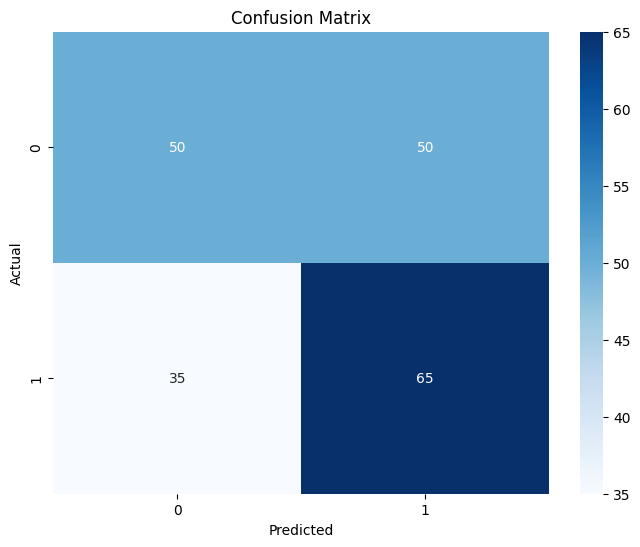

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       100
           1       0.57      0.65      0.60       100

    accuracy                           0.57       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200



In [33]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report for detailed metrics
print(classification_report(y_test, y_pred))